In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt     
from matplotlib.pyplot import figure
import pandas as pd
import os,pickle
from sklearn.metrics import confusion_matrix,accuracy_score

from torch.utils.data import Dataset,DataLoader
from torch import nn
import torch
from pytorch_lightning import LightningDataModule, LightningModule
from pytorch_lightning import Trainer
from trainerPOS_tagging import POStag_net,MyDataModule
from sklearn.metrics import accuracy_score


# Nome: Guilherme Cramer Barbosa Silva

# Matrícula: 2021666152

## Introdução:

O trabalho em questão é o aprender uma representação de POS tagging de um corpus em português do Brasil. Ou seja, dado um conjunto de palavras e suas respectivas classes gramaticais, visa-se criar um modelo que aprenda a classificar qual a classe gramatical de uma certa palavra.

Para foi promosto um modelo de Deep Learning baseado em rede LSTM que será melhor explicado na Seção Metodologia. Esse modelo tem como entrada uma sequência de 3 palavras e como saída um rótulo classe gramatical de uma das palavras. 

Para a construção do dataset, usou-se a tecnica 3-gram, ou seja, cada instancia do dataset é uma sequência de 3 palavras associado ao label de uma delas. Basicamente, o dataset de treino é construido da seguinte forma: A palavra do meio tem o label associada a ela e a palavra da direita e da esquerda é usada como contexto. 

Para a representação da palavra, foi usado o embadding da biblioteca spacy para português (spacy.load("pt_core_news_md")). E os labels foram criados enumarados a medida que o algoritimo tinha acesso a uma nova TAG. Assim, as dimentsões da entrada foram (samples,3,300) e da saída (samples,)



## Metodologia:

A metodologia foi baseada em uma camada com 2 LSTM empilhadas usando a forma bidirecional.
O hidden_size escolhido foi de 128 e a saída da LSTM tem um Dropout de p= 0.2 
A saída da camada LSTM é passada por uma camada totalmente conectada que prevê qual a probabilidade de cada classe através da função Softmax. 

Esse modelo foi escolhido pela sua robustez já conhecida pela literatura e pela sua capacidade de relacionar temporalmente a sequencia de palavras. 



## Experiments: 
O modelo foi criado com auxilido do framework Pytorch e do pytorch_lighting. Esses dois frameworks facilitam muito o treinamento do modelo. 

Os experimentos foram Basicamente mediu a qualidade de classificação do modelo. Foi usado a acurácia e a matriz de confusão. 

Na conclusão será discutido algumas possíveis razões para o desempenho do modelo como um todo e o desempenho relativo a cada uma das classes. 

#### Implementação:.
Para a execução do código é necessário usar dois arquivos - que estão em anexo. O primeiro arquivo tem a função de realizar o pré-processamento dos dados e salvá-los. Esse codigo salva os dados de treino, dev e test de forma indexada, ou seja, cada palavra é representada como um íncide único dessa palavra. Além disso um arquivo "Vocab" que é um dicionario que realiza esse mapeamento dos ídices para os embaddings. Outro arquivo gerado é o das "classes" que tem a funcionalidade de salvar o indice de cada uma das classes e o seu nome, isso é feito para que os mesmos indices sejam usados no treino dev e test. 

O segundo arquivo python é onde está o modelo de fato. Basicamente é declarado o modelo em pytorch (nn.Module) de acordo com o que foi explicado na Metodologia. Depois é declarado o modelo do pytorch_lighting que tem a funcção de gerenciar as questões de treinamento, validação e teste; nele é declarado a loss usada e o otimizador e o learning_rate. 
Por fim, neste arquivo também tem a classe do LightningDataModule que basicamente é usada para servir os dados em batchs para o modelo. 


#### Como executar:
Basta acessar o código POS_tagging_preprocessing.py, descomentar o final (main) e colocar os caminhos dos arquivos desejados. 
Após isso, basta acessar o código POS_tagging_trainer.py, descomentar o final (main)e colocar os caminhos dos arquivos desejados para o modelo acessar os dados já processados. 

Será enviado em anexo o modelo já treinado, de tal forma que esse notebook seja totalmente executável. 

Infelizmente não é possível enviar os dados para outros testes. Pois o "Vocab" é maior que 50 mb. Mas é fácil de gerar a partir dos códigos.

Basta ficar atento as bibliotecas ultilizadas. A maioria é de grande conhecimeto de especialistas da área. Lembre-se de ter baixado o Modelo de linguagem em portugues do Spacy e o pytorch-lighting. 
A versão do pytorch usada foi 1.9.0 + cuda 10.2 



### Experimentos: 

In [17]:
PATH_MODEL = "C:\\Users\\gcram\\Documents\\Datasets\\NLP\\saved\\POStag_model.ckpt"
path_file = "C:\\Users\\gcram\\Documents\\Datasets\\NLP\\pos_tagging\\"

dm = MyDataModule(batch_size = 256)
dm._setup(path_file)

In [18]:
model = POStag_net.load_from_checkpoint(PATH_MODEL)
outcomes = model.predict(dm.test_dataloader(),'test')
print("Acurácia de teste: ",accuracy_score(outcomes['true_test'], outcomes['pred_test']))

Acurácia de teste:  0.894134963768116


Text(0.5, 1.0, 'Confusion Matrix')

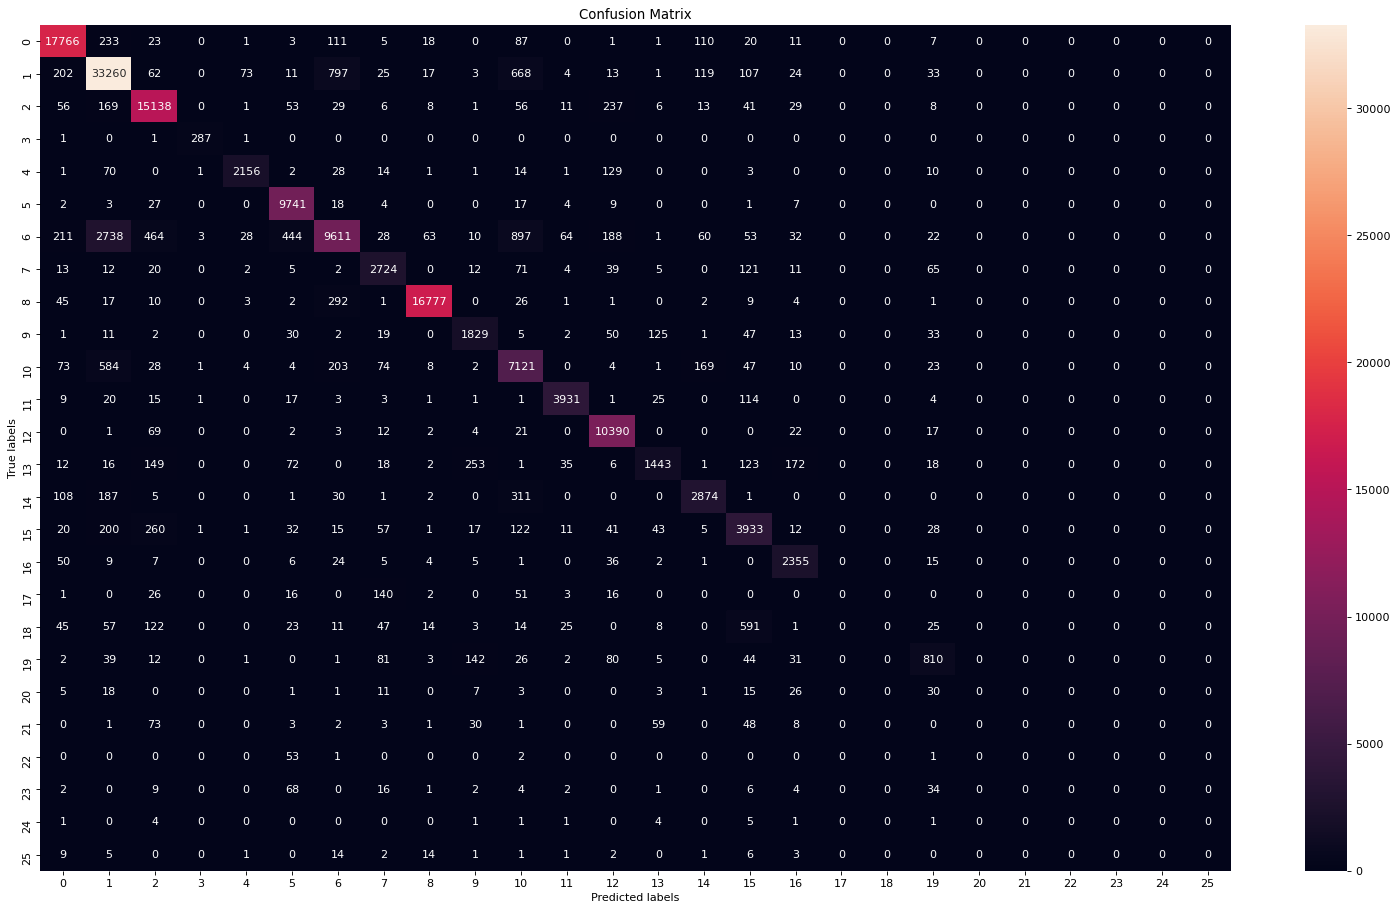

In [21]:


figure(figsize=(24, 14), dpi=80)
cm = confusion_matrix(outcomes['true_test'], outcomes['pred_test'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(dm.n_classes.keys())
# ax.yaxis.set_ticklabels(dm.n_classes.keys())

In [22]:
print("Classes Names: \n",dm.n_classes)

Classes Names: 
 {'V': 0, 'N': 1, 'PREP': 2, 'CUR': 3, 'NUM': 4, 'PREP+ART': 5, 'NPROP': 6, 'PROADJ': 7, 'PU': 8, 'PRO-KS': 9, 'ADJ': 10, 'KC': 11, 'ART': 12, 'KS': 13, 'PCP': 14, 'ADV': 15, 'PROPESS': 16, 'PREP+PROADJ': 17, 'PDEN': 18, 'PROSUB': 19, 'PREP+PROPESS': 20, 'ADV-KS': 21, 'PREP+PRO-KS': 22, 'PREP+PROSUB': 23, 'PREP+ADV': 24, 'IN': 25}


### Conclusão:

A partir da análise dos resultados e da visualização da matriz é possível concluir que o desempenho é muito satisfatório. 

A acurácia de 89.41 na partição de teste para um problema de 26 classes é de fato excelente. Primcimalmente dado a simplicidade do modelo ultilizado. 

O modelo realizou apenas duas confusões notáveis. A primeira é a previsão da classe 1 quando na verdade era 6 e A previsão da classe 6 quando era 1. Essas classes representam NOME e NOMOPROPRIO o que é realmente plausível de confusão. 

Outro erro foi a previsão da classe 10, quando era 6 em que a classe 10 é ADJETIVO. Ess problema realmente seria critico e carece me aprimoramento para os próximos passos. 

